# Week 8 - MINST Bagging

*Using the MNIST hand-written character dataset, use bagging to improve your method. Submit your code and a summary of the results. How much better/worse are your results?*

### 1 MNIST character recognition without bagging

This script is modified from: https://github.com/Vict0rSch/deep_learning/tree/master/keras/feedforward

In [1]:
import time
import numpy as np
from matplotlib import pyplot as plt
from keras.utils import np_utils
import keras.callbacks as cb
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop
from keras.datasets import mnist

Using Theano backend.


In [13]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)

In [3]:
def load_data():
    print 'Loading data...'
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    X_train /= 255
    X_test /= 255

    y_train = np_utils.to_categorical(y_train, 10)
    y_test = np_utils.to_categorical(y_test, 10)

    X_train = np.reshape(X_train, (60000, 784))
    X_test = np.reshape(X_test, (10000, 784))

    print 'Data loaded.'
    return [X_train, X_test, y_train, y_test]


In [4]:
def init_model():
    start_time = time.time()
    print 'Compiling Model ... '
    model = Sequential()
    model.add(Dense(500, input_dim=784))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(300))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    rms = RMSprop()
    model.compile(loss='categorical_crossentropy', optimizer=rms, metrics=['accuracy'])
    print 'Model compield in {0} seconds'.format(time.time() - start_time)
    return model

In [23]:
def run_network(data=None, model=None, epochs=20, batch=256):
    try:
        start_time = time.time()
        if data is None:
            X_train, X_test, y_train, y_test = load_data()
        else:
            X_train, X_test, y_train, y_test = data

        if model is None:
            model = init_model()

        history = LossHistory()

        print 'Training model...'
        model.fit(X_train, y_train, nb_epoch=epochs, batch_size=batch,
                  callbacks=[history], validation_data=(X_test, y_test), verbose=2)

        print "Training duration : {0}".format(time.time() - start_time)
        score = model.evaluate(X_test, y_test, batch_size=16, verbose = 0)

        print "Network's test score [loss, accuracy]: {0}".format(score)
        return model, history.losses
    
    except KeyboardInterrupt:
        print ' KeyboardInterrupt'
        return model, history.losses

In [24]:
model, losses = run_network()

Loading data...
Data loaded.
Compiling Model ... 
Model compield in 0.254482984543 seconds
Training model...
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
10s - loss: 0.3567 - acc: 0.8918 - val_loss: 0.1392 - val_acc: 0.9561
Epoch 2/20
9s - loss: 0.1512 - acc: 0.9540 - val_loss: 0.1036 - val_acc: 0.9684
Epoch 3/20
9s - loss: 0.1122 - acc: 0.9654 - val_loss: 0.0812 - val_acc: 0.9768
Epoch 4/20
10s - loss: 0.0927 - acc: 0.9717 - val_loss: 0.0769 - val_acc: 0.9781
Epoch 5/20
12s - loss: 0.0796 - acc: 0.9760 - val_loss: 0.0798 - val_acc: 0.9774
Epoch 6/20
10s - loss: 0.0710 - acc: 0.9779 - val_loss: 0.0742 - val_acc: 0.9806
Epoch 7/20
10s - loss: 0.0631 - acc: 0.9802 - val_loss: 0.0732 - val_acc: 0.9804
Epoch 8/20
10s - loss: 0.0599 - acc: 0.9816 - val_loss: 0.0759 - val_acc: 0.9808
Epoch 9/20
10s - loss: 0.0531 - acc: 0.9837 - val_loss: 0.0745 - val_acc: 0.9821
Epoch 10/20
10s - loss: 0.0490 - acc: 0.9848 - val_loss: 0.0798 - val_acc: 0.9790
Epoch 11/20
10s - loss: 0.0469 -

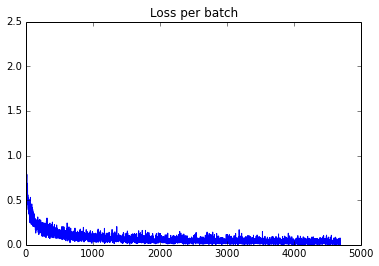

In [25]:
def plot_losses(losses):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(losses)
    ax.set_title('Loss per batch')
    fig.show()

plot_losses(losses)